<img src="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


## Что имеется: 
    Есть только небольшой датасет с историей продаж за короткий период, которого для обучения модели будет явно мало. Его мы будем использовать для теста.
    

## Чего не хватает:
    Данных для обучения модели. Данные собраны самостоятельно с auto.ru. Ссылка на код будет приложена дополнительно.

## Как будем оценивать:

    С помощью MAPE  (Mean Percentage Absolute Error) - средней абсолютной ошибки в процентах.

In [130]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from pandas import Series

import seaborn as sns
from tqdm.notebook import tqdm


import re
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 50)  
pd.set_option('display.max_columns', 50)

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
label_encoder = LabelEncoder()
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score, KFold,RepeatedKFold, StratifiedKFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

from sklearn.base import clone




from mlxtend.regressor import StackingRegressor
from category_encoders.cat_boost import CatBoostEncoder
from tqdm.notebook import tqdm

from category_encoders.ordinal import OrdinalEncoder


#функция для опеределения средней стоимости автомобиля по категориям признака


def mean_price_by(column):
    return train.groupby([column])[['Price']].mean().sort_values(['Price'],
                                                          ascending=False)

import warnings
warnings.filterwarnings("ignore")


#функция для работы с пропусками

def data_gaps(df):
    mis_val = df.isnull().sum()
    percent = 100 * df.isnull().sum() / len(df)
    mis_table = pd.DataFrame({
        'Missing Values': mis_val,
        '% of Total Values': percent
    })
    return mis_table


#функция, выводящая все уникальные значения и их количество
    
    
def unique_values(df, column):
    display(pd.DataFrame(df[column].value_counts(dropna=True)))
    s = sns.catplot(x=column, kind="count", palette="Blues", data=df)
    s.set_xticklabels(rotation=45)
    
    
def gen_stat(column):
    minimum = train[column].min()
    maximum = train[column].max()
    IQR = train[column].quantile(0.75) - train[column].quantile(0.25)
    perc25 = train[column].quantile(0.25)
    perc75 = train[column].quantile(0.75)
    print(
        'Минимальное значение: {}'.format(minimum),
        '\nМаксимальное значение: {}'.format(maximum),
        '\n25-й перцентиль: {}'.format(perc25),
        '\n75-й перцентиль: {}'.format(perc75), '\nIQR: {}'.format(IQR),
        '\nГраницы выбросов: [{f}, {l}]'.format(f=perc25 - 1.5 * IQR,
                                                l=perc75 + 1.5 * IQR))

    

    
#функция, определяющая распределение средней стоимости автомобиля относительно его возраста
    
def price_by(column):
    return train.groupby(
        train[column])['Price'].mean().to_frame().reset_index().sort_values(
            by=[column]).plot.line(x=column, y='Price')  


#функция для построения графика зависимости от целевого признака


def price_plot(column):
    return sns.lmplot(x=column,
                      y="Price",
                      hue="ПТС",
                      data=train,
                      markers=["o", "x"],
                      palette="Set1")



#функция, определяющая границы выбросов


def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [5, 95])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound


#функция для расчета mape

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


# отмечаем функцию для скоринга
mape_score = make_scorer(mape, greater_is_better=False)

from sklearn import preprocessing


In [131]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

zsh:1: command not found: pip


In [132]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
VAL_SIZE = 0.2

# Data

In [133]:
train = pd.read_csv('train.csv') # датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train_1 = pd.read_csv('../input/sf-scoring/train.csv')
test_1 = pd.read_csv('../input/sf-scoring/test.csv')
sample_submission = pd.read_csv('../input/sf-scoring/sample_submission.csv')

bodyType - тип кузова.

brand - марка.

color - цвет.

fuelType - тип топлива.

modelDate - год модели.

name - включает несколько видов данных, требует обработки.

numberOfDoors - кол-во дверей.

productionDate - дата выпуска.

vehicleConfiguration - включает несколько видов данных, требует обработки.

vehicleTransmission - тип коробки передач.

engineDisplacement - объем двигателя автомобиля.

enginePower - мощность двигателя.

description - описание, требует обработки.

mileage - километраж.

Комплектация - включает несколько видов данных, требует обработки.

Привод - вид привода.

Руль - расположение руля.

Состояние - состояние авто.

Владельцы - количество владельцев.

ПТС - наличие оригинала паспорта.

Таможня - прохождение таможни.

Владение - срок владения.

In [134]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68895 entries, 0 to 68894
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             68894 non-null  object 
 1   brand                68895 non-null  object 
 2   model_name           68895 non-null  object 
 3   color                68895 non-null  object 
 4   fuelType             68895 non-null  object 
 5   modelDate            68894 non-null  float64
 6   name                 68894 non-null  object 
 7   numberOfDoors        68894 non-null  float64
 8   productionDate       68895 non-null  int64  
 9   vehicleTransmission  68894 non-null  object 
 10  engineDisplacement   68894 non-null  object 
 11  enginePower          68894 non-null  float64
 12  description          66680 non-null  object 
 13  mileage              68895 non-null  int64  
 14  vendor               68895 non-null  object 
 15  Комплектация         68895 non-null 

In [135]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

В датасете 6 числовых признаков, остальные - dtype object.

In [136]:
dataset_info = lambda df: pd.DataFrame({
    'Shape': [df.shape] + ['' for x in range(len(df.columns) - 1)], 
    'Columns': df.columns, 
    'Non-Null Count': [df[col].count() for col in df.columns]
})

pd.concat([dataset_info(train), 
           dataset_info(test)], 
          keys = ['ОБУЧАЮЩАЯ ВЫБОРКА', 'ТЕСТОВАЯ ВЫБОРКА'], 
          axis = 1, sort = False
         ).fillna('')
pd.concat([dataset_info(train), 
           dataset_info(test)], 
          keys = ['ОБУЧАЮЩАЯ ВЫБОРКА', 'ТЕСТОВАЯ ВЫБОРКА'], 
          axis = 1, sort = False
         ).fillna('')

ОБУЧАЮЩАЯ ВЫБОРКА                                     ТЕСТОВАЯ ВЫБОРКА  \
               Shape              Columns Non-Null Count            Shape   
0        (68895, 23)             bodyType        68894.0      (34686, 32)   
1                                   brand        68895.0                    
2                              model_name        68895.0                    
3                                   color        68895.0                    
4                                fuelType        68895.0                    
5                               modelDate        68894.0                    
6                                    name        68894.0                    
7                           numberOfDoors        68894.0                    
8                          productionDate        68895.0                    
9                     vehicleTransmission        68894.0                    
10                     engineDisplacement        68894.0                    
11                            enginePower        68894.0                    
12                            description        66680.0                    
13                                mileage        68895.0                    
14                                 vendor        68895.0                    
15                           Комплектация        68895.0                    
16                                 Привод        68894.0                    
17                                   Руль        68895.0                    
18                              Владельцы        68895.0                    
19                                    ПТС        68893.0                    
20                                Таможня        68895.0                    
21                               Владение        21303.0                    
22                                  Price        68895.0                    
23                                                                          
24                                                                          
25                                                                          
26                                                                          
27                                                                          
28                                                                          
29                                                                          
30                                                                          
31                                                                          

                                         
                 Columns Non-Null Count  
0               bodyType          34686  
1                  brand          34686  
2                car_url          34686  
3                  color          34686  
4     complectation_dict           6418  
5            description          34686  
6     engineDisplacement          34686  
7            enginePower          34686  
8         equipment_dict          24690  
9               fuelType          34686  
10                 image          34686  
11               mileage          34686  
12             modelDate          34686  
13            model_info          34686  
14            model_name          34686  
15                  name          34686  
16         numberOfDoors          34686  
17      parsing_unixtime          34686  
18         priceCurrency          34686  
19        productionDate          34686  
20               sell_id          34686  
21             super_gen          34686  
22  vehicleConfiguration          34686  
23   vehicleTransmission          34686  
24                vendor          34686  
25             Владельцы          34686  
26              Владение          11995  
27                   ПТС          34685  
28                Привод          34686  
29                  Руль          34686  
30             Состояние          34686 

## Data Preprocessing

In [137]:
data_gaps(test)

,Missing Values,% of Total Values
bodyType,0,0.000000
brand,0,0.000000
car_url,0,0.000000
color,0,0.000000
complectation_dict,28268,81.496858
description,0,0.000000
engineDisplacement,0,0.000000
enginePower,0,0.000000
equipment_dict,9996,28.818544
fuelType,0,0.000000


In [138]:
data_gaps(train)

,Missing Values,% of Total Values
bodyType,1,0.001451
brand,0,0.000000
model_name,0,0.000000
color,0,0.000000
fuelType,0,0.000000
modelDate,1,0.001451
name,1,0.001451
numberOfDoors,1,0.001451
productionDate,0,0.000000
vehicleTransmission,1,0.001451


В тестовом датасете есть три признака со значительным количеством пропущенных значений.


В тренировочном - таких признака 2.

Признак "Владение" плохо заполнен в обоих датасетах.

Проверим уникальность значений.

In [139]:
test.nunique(axis=0)

bodyType                   24
brand                      12
car_url                 34686
color                      16
complectation_dict       2364
description             31732
engineDisplacement         55
enginePower               315
equipment_dict          23705
fuelType                    5
image                   34557
mileage                 11268
modelDate                  66
model_info                954
model_name                544
name                     2780
numberOfDoors               5
parsing_unixtime        34686
priceCurrency               1
productionDate             69
sell_id                 34686
super_gen                5890
vehicleConfiguration      634
vehicleTransmission         4
vendor                      2
Владельцы                   3
Владение                  275
ПТС                         2
Привод                      3
Руль                        2
Состояние                   1
Таможня                     1
dtype: int64

In [140]:
train.nunique(axis=0)

bodyType                 127
brand                     17
model_name               728
color                     16
fuelType                   6
modelDate                 71
name                    3537
numberOfDoors              4
productionDate            72
vehicleTransmission        4
engineDisplacement       430
enginePower              338
description            58537
mileage                20616
vendor                     5
Комплектация            4227
Привод                     3
Руль                       2
Владельцы                  4
ПТС                        2
Таможня                    1
Владение                 293
Price                   4821
dtype: int64

priceCurrency, Состояние и Таможня имеют одну категорию. Для нас это может быть сигналом не использовать данные при обучении.

In [141]:
cols_to_drop_train = []
cols_to_drop_test = []



Для начала разделим признаки на категории:

**Категориальные** : 'bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 
'Таможня', 'Владельцы', 'Владение', 'Привод', 'ПТС', 'Руль'

**Даты**: 'modelDate', 'productionDate'

**Количественные**: 'engine Displacement', 'enginePower', 'mileage', 'Price'

**Смешанные**: 'complectation_dict', 'description', 'equipment_dict', 'model_info', 'name'

## Целевая переменная

In [142]:
gen_stat('Price')

Минимальное значение: 18888 
Максимальное значение: 27800000 
25-й перцентиль: 400000.0 
75-й перцентиль: 1390000.0 
IQR: 990000.0 
Границы выбросов: [-1085000.0, 2875000.0]


<AxesSubplot:xlabel='Price', ylabel='Density'>

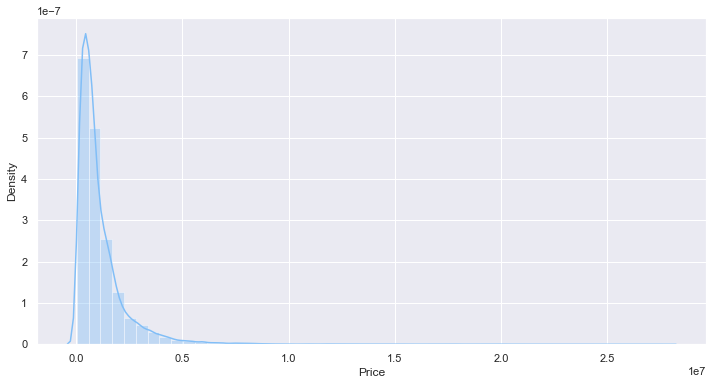

In [143]:
sns.set()
plt.figure(figsize = (12, 6))
sns.distplot(train['Price'], color = '#81BEF7')

## bodyType - тип кузова

In [144]:
test['bodyType'].value_counts()

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
лимузин                        6
седан 2 дв.                    6
пикап полуторная кабина        5
пикап одинарная кабина         5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [145]:
train['bodyType'].value_counts()

Седан                                26581
Внедорожник 5 дв.                    23124
Хэтчбек 5 дв.                         6224
Лифтбек                               2626
Универсал 5 дв.                       2389
                                     ...  
Купе T160                                1
Седан 120                                1
Пикап Одинарная кабина 79                1
Пикап Одинарная кабина Single Cab        1
Седан Asian Market                       1
Name: bodyType, Length: 127, dtype: int64

 В обоих датасетах в топе находятся известные типы кузовов, а замыкают список редкие разновидности. В тренировочном типов кузовов значительно больше, так как при парсинге были собраны данные по большему кличество марок авто.

Не забудем и про пропущенное значение.

In [146]:
train[train['bodyType'].isnull()]

,bodyType,brand,model_name,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,description,mileage,vendor,Комплектация,Привод,Руль,Владельцы,ПТС,Таможня,Владение,Price
1467,NaN,HONDA,CIVIC,CACECB,универсал,NaN,NaN,NaN,1989,NaN,NaN,NaN,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",400000,JAPANESE,"{'id': '0', 'name': ''}",NaN,LEFT,3,ORIGINAL,True,NaN,120000


Это объявление в целом некорректно заполнено - много пропусков. Удалим его.

In [147]:
train.dropna(subset=['bodyType'], how='all', inplace=True)

In [148]:
data_gaps(train)

,Missing Values,% of Total Values
bodyType,0,0.000000
brand,0,0.000000
model_name,0,0.000000
color,0,0.000000
fuelType,0,0.000000
modelDate,0,0.000000
name,0,0.000000
numberOfDoors,0,0.000000
productionDate,0,0.000000
vehicleTransmission,0,0.000000


## brand - марка авто

,brand
BMW,4473
VOLKSWAGEN,4404
NISSAN,4393
MERCEDES,4180
TOYOTA,3913
AUDI,3421
MITSUBISHI,2843
SKODA,2741
VOLVO,1463
HONDA,1150


,brand
VOLKSWAGEN,6996
KIA,6964
HYUNDAI,6573
MERCEDES,6503
BMW,5938
TOYOTA,5609
NISSAN,5398
CHEVROLET,4218
RENAULT,3873
AUDI,3766


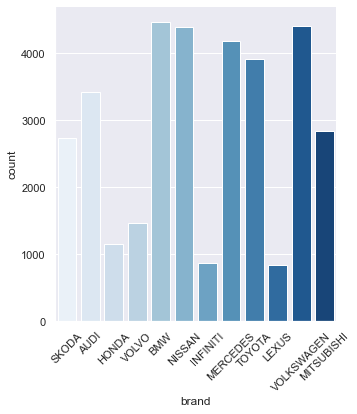

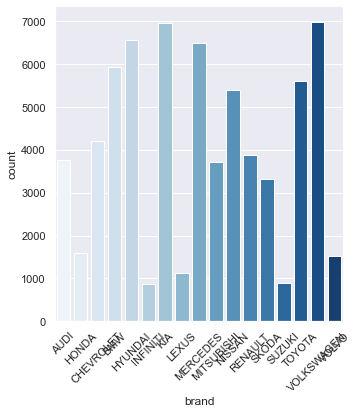

In [149]:
unique_values(test, 'brand')
unique_values(train, 'brand')

Интересно, что в тестовом датасете BMW в уверенных лидерах, а в свежесобранном - в хвосте по количеству предложений.

In [150]:
mean_price_by('brand')

,Price
brand,
LEXUS,2.682956e+06
MERCEDES,2.430951e+06
BMW,1.932080e+06
INFINITI,1.588444e+06
TOYOTA,1.437331e+06
AUDI,1.217439e+06
VOLVO,1.105882e+06
KIA,8.791271e+05
VOLKSWAGEN,8.402443e+05


## color

In [151]:
test['color'].value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

In [152]:
train['color'].value_counts()

040001    18265
FAFBFB    13238
97948F     9059
CACECB     8266
0000CC     6592
EE1D19     3611
200204     3085
007F00     2031
C49648     1658
22A0F8      957
DEA522      494
660099      438
FFD600      415
4A2197      395
FF8649      370
FFC0CB       20
Name: color, dtype: int64

Чёрный цвет, ожидаемо, самый популярный.

Здесь нужно поработать, так как форматы цвета не совпадают.

In [153]:
color_dict = {'CACECB': 'серебристый', 
              'FAFBFB':'белый', 
              'EE1D19':'красный', 
              '97948F':'серый',
              '660099':'пурпурный',
              '040001':'чёрный',
              '4A2197':'фиолетовый',
              '200204':'коричневый',
              '0000CC':'синий',
              '007F00':'зелёный',
              'C49648':'бежевый',
              '22A0F8':'голубой',
              'DEA522':'золотистый',
              'FFD600': 'жёлтый',
              'FF8649':'оранжевый',
              'FFC0CB':'розовый',
              'серебристый': 'серебристый', 
              'белый':'белый', 
              'красный':'красный', 
              'серый':'серый',
              'пурпурный':'пурпурный',
              'чёрный':'чёрный',
              'фиолетовый':'фиолетовый',
              'коричневый':'коричневый',
              'синий':'синий',
              'зелёный':'зелёный',
              'бежевый':'бежевый',
              'голубой':'голубой',
              'золотистый':'золотистый',
              'жёлтый': 'жёлтый',
              'оранжевый':'оранжевый',
              'розовый':'розовый'
             }
train.color = train.color.map(color_dict)

In [154]:
train['color'].value_counts()

чёрный         18265
белый          13238
серый           9059
серебристый     8266
синий           6592
красный         3611
коричневый      3085
зелёный         2031
бежевый         1658
голубой          957
золотистый       494
пурпурный        438
жёлтый           415
фиолетовый       395
оранжевый        370
розовый           20
Name: color, dtype: int64

Другое дело! Можем видеть, что предпочтения не изменились. Черный и белый в лидерах. Причём, как по популярности, так и по стоимости.

In [155]:
mean_price_by('color')

,Price
color,
чёрный,1.508020e+06
коричневый,1.322743e+06
белый,1.310648e+06
серый,1.028013e+06
синий,1.004541e+06
оранжевый,9.071276e+05
жёлтый,8.221439e+05
бежевый,7.593426e+05
фиолетовый,7.479275e+05


## fuelType - тип топлива

,fuelType
бензин,28601
дизель,5800
гибрид,223
электро,55
газ,7


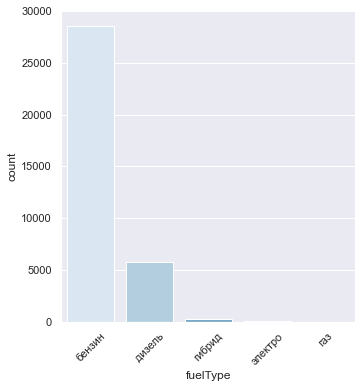

In [156]:
unique_values(test, 'fuelType')

,fuelType
бензин,58518
дизель,9928
гибрид,286
электро,153
газ,9


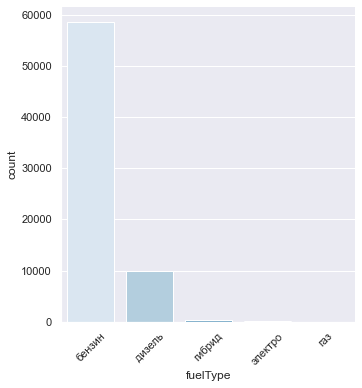

In [157]:
unique_values(train, 'fuelType')

Самые дорогие авто - на дизеле.

In [158]:
mean_price_by('fuelType')


,Price
fuelType,
дизель,2.101856e+06
гибрид,1.417339e+06
электро,1.342762e+06
газ,9.793333e+05
бензин,9.665063e+05


## numberOfDoors - количество дверей


,numberOfDoors
5,18703
4,14126
2,1206
3,650
0,1


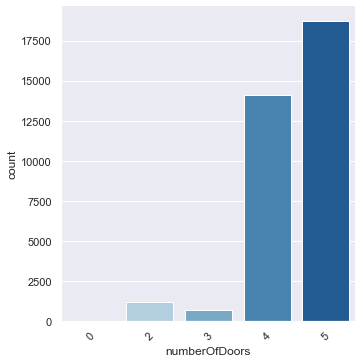

In [159]:
unique_values(test, 'numberOfDoors')

In [160]:
train['numberOfDoors'] = train['numberOfDoors'].fillna(train['numberOfDoors'].mode()[0])


,numberOfDoors
5.0,37373
4.0,28864
2.0,1609
3.0,1048


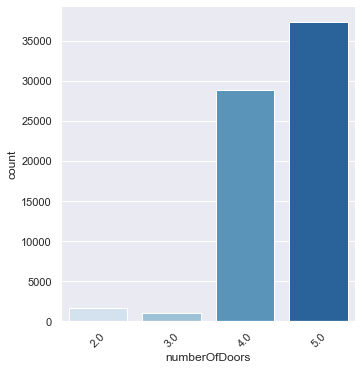

In [161]:
unique_values(train, 'numberOfDoors')


В тестовом датасете видим модель с 0 дверей. Проверим, нет ли ошибки.

In [162]:
test[test['numberOfDoors'] == 0]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 л.с.),0,1603245843,RUB,1904,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен


Кабриолет 1904-го года! Значит, не ошибка.

In [163]:
train['numberOfDoors'] = train['numberOfDoors'].astype('int64')


In [164]:
mean_price_by('numberOfDoors')

,Price
numberOfDoors,
2,2.037959e+06
5,1.322506e+06
4,8.611289e+05
3,4.619746e+05


2-дверные машины показывают самые высокие цены.

## vehicleTransmission - тип коробки передач

,vehicleTransmission
автоматическая,19596
механическая,7209
вариатор,3999
роботизированная,3882


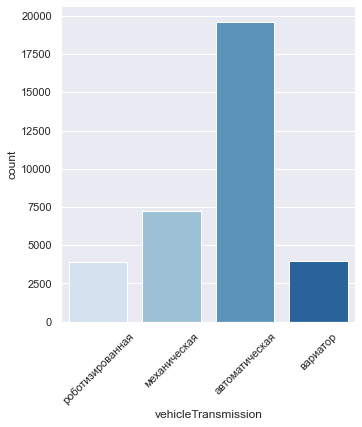

In [165]:
unique_values(test, 'vehicleTransmission') 

,vehicleTransmission
AUTOMATIC,36247
MECHANICAL,22636
VARIATOR,5043
ROBOT,4968


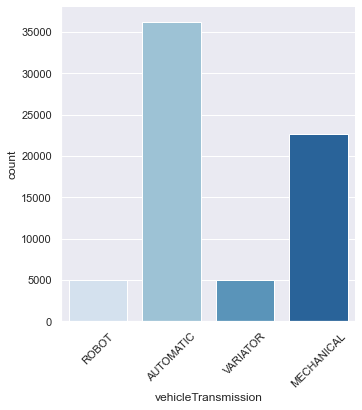

In [166]:
unique_values(train, 'vehicleTransmission') 

Приведём данные к единому виду.

In [167]:
d_dict = {'MECHANICAL': 'механическая', 
            'AUTOMATIC':'автоматическая', 
            'VARIATOR':'вариатор', 
            'ROBOT':'роботизированная',
            'механическая': 'механическая', 
            'автоматическая':'автоматическая', 
            'вариатор':'вариатор', 
            'роботизированная':'роботизированная'
             }
train.vehicleTransmission = train.vehicleTransmission.map(d_dict)

In [168]:
train['vehicleTransmission'].value_counts()

автоматическая      36247
механическая        22636
вариатор             5043
роботизированная     4968
Name: vehicleTransmission, dtype: int64

In [169]:
mean_price_by('vehicleTransmission')

,Price
vehicleTransmission,
автоматическая,1.519976e+06
роботизированная,1.414869e+06
вариатор,1.081048e+06
механическая,4.625162e+05


Авто с механической коробкой передач, что логично, имеют самые низкие цены.

## vendor - страна-изготовитель

,vendor
EUROPEAN,31922
JAPANESE,19217
KOREAN,13534
AMERICAN,3124
RUSSIAN,1097


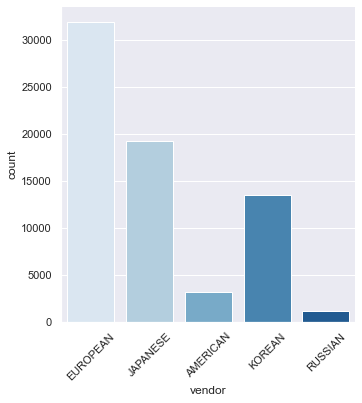

In [170]:
unique_values(train, 'vendor')

,vendor
EUROPEAN,20682
JAPANESE,14004


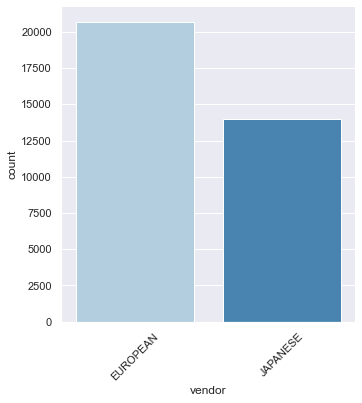

In [171]:
unique_values(test, 'vendor')

In [172]:
mean_price_by('vendor')

,Price
vendor,
EUROPEAN,1.378063e+06
JAPANESE,1.072970e+06
KOREAN,8.426963e+05
AMERICAN,5.251347e+05
RUSSIAN,3.550519e+05


В тестовой и тренировочных датасетах разнится количество стран-категорий. Это объяняется тем, что для тренировочного датасета было выбрано больше марок автомобилей.

Авто российских производителей замыкают рейтинг по стоимости.

## 'Владельцы'

,Владельцы
3 или более,15957
1 владелец,9459
2 владельца,9270


,Владельцы
1,20492
3,18606
2,17517
4,12279


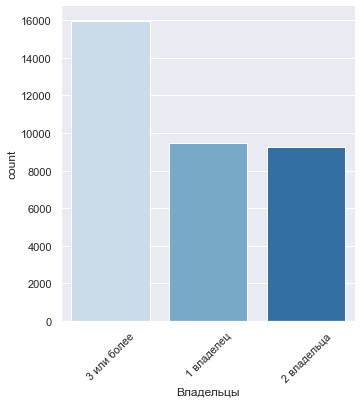

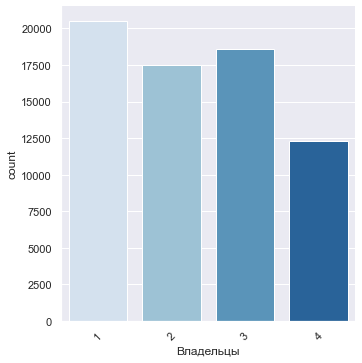

In [173]:
unique_values(test, 'Владельцы')
unique_values(train, 'Владельцы')

Признак разнится. В тестововй выборке всего три категории, а в тренировочной - 4. Объединими 3 и 4 категорию в одну в тренировочном датасете.

In [174]:
train.loc[train['Владельцы'] > 3, 'Владельцы'] = 3

In [175]:
test['Владельцы'] = test['Владельцы'].astype(str).apply(lambda x: x[0])

Проверим:

In [176]:
test['Владельцы'].value_counts()

3    15957
1     9459
2     9270
Name: Владельцы, dtype: int64

In [177]:
train['Владельцы'].value_counts()

3    30885
1    20492
2    17517
Name: Владельцы, dtype: int64

In [178]:
mean_price_by('Владельцы')

,Price
Владельцы,
1,1.723590e+06
2,1.206532e+06
3,6.990525e+05


## Владение

In [179]:
train['Владение'] = train['Владение'].fillna('Не указано')
test['Владение'] = test['Владение'].fillna('Не указано')

In [180]:
train['Владение'].value_counts()

Не указано                     47591
{'year': 2020, 'month': 9}       415
{'year': 2020, 'month': 10}      412
{'year': 2020, 'month': 11}      384
{'year': 2021, 'month': 1}       374
                               ...  
{'year': 2001, 'month': 5}         1
{'year': 2001, 'month': 11}        1
{'year': 2000, 'month': 12}        1
{'year': 1998, 'month': 10}        1
{'year': 1996, 'month': 9}         1
Name: Владение, Length: 294, dtype: int64

In [181]:
mean_price_by('Владение')

,Price
Владение,
"{'year': 2004, 'month': 12}",9.250000e+06
"{'year': 2006, 'month': 7}",2.361750e+06
"{'year': 1986, 'month': 8}",2.000000e+06
"{'year': 2000, 'month': 11}",2.000000e+06
"{'year': 2003, 'month': 10}",1.961667e+06
...,...
"{'year': 1997, 'month': 12}",9.300000e+04
"{'year': 2000, 'month': 5}",9.000000e+04
"{'year': 1997, 'month': 11}",8.699900e+04


## ПТС - наличие оригинального документа или дубликата

,ПТС
Оригинал,30098
Дубликат,4587


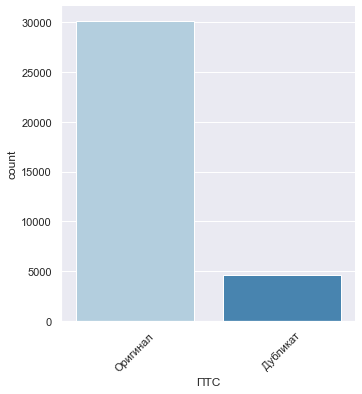

In [182]:
unique_values(test, 'ПТС')

,ПТС
ORIGINAL,59080
DUPLICATE,9812


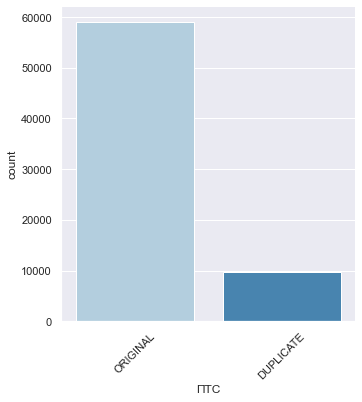

In [183]:
unique_values(train, 'ПТС')

In [184]:
train['ПТС'] = train['ПТС'].fillna(train['ПТС'].mode()[0])
test['ПТС'] = test['ПТС'].fillna(train['ПТС'].mode()[0])

In [185]:
pas_dict = {'ORIGINAL': 'Оригинал', 
            'DUPLICATE':'Дубликат',
            'Оригинал': 'Оригинал', 
            'Дубликат':'Дубликат'
            
             }
train['ПТС'] = train['ПТС'].map(pas_dict)

In [186]:
mean_price_by('ПТС')

,Price
ПТС,
Оригинал,1.215406e+06
Дубликат,6.355749e+05


Заметна разница в цене между машинами с оригинальным паспортом и копией, что вполне справедливо.

## Привод

,Привод
передний,15565
полный,15020
задний,4101


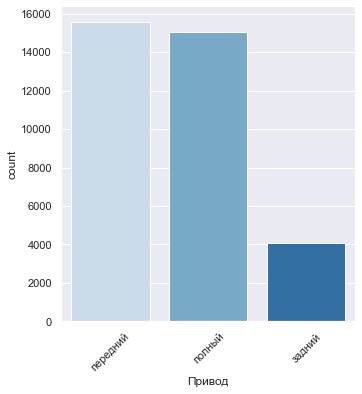

In [187]:
unique_values(test, 'Привод')


,Привод
передний,38005
полный,24804
задний,6085


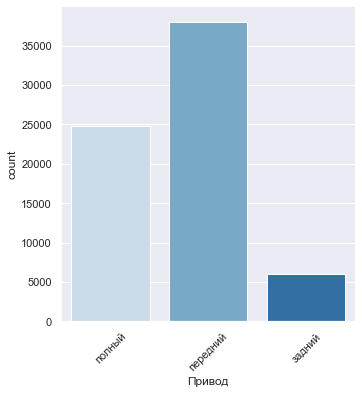

In [188]:
unique_values(train, 'Привод')

In [189]:
mean_price_by('Привод')

,Price
Привод,
полный,1.881889e+06
задний,1.147354e+06
передний,6.416222e+05


Машины с полным приводом в целом дороже остальных.

## Руль

,Руль
Левый,33287
Правый,1399


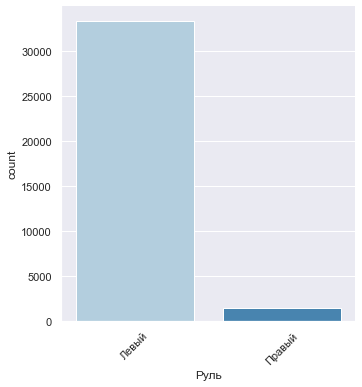

In [190]:
unique_values(test, 'Руль')

In [191]:
rul_dict = {'LEFT': 'Левый', 
            'RIGHT':'Правый',
            'Левый': 'Левый', 
            'Правый':'Правый'
            
             }
train['Руль'] = train['Руль'].map(rul_dict)

,Руль
Левый,66684
Правый,2210


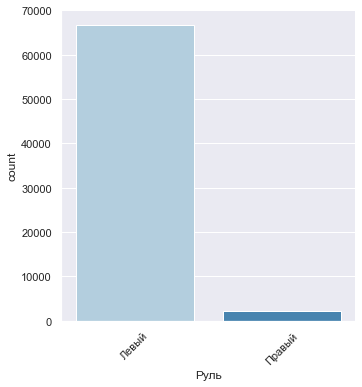

In [192]:
unique_values(train, 'Руль')

In [193]:
mean_price_by('Руль')

,Price
Руль,
Левый,1.155737e+06
Правый,4.414884e+05


In [194]:
test.value_counts('Руль')

Руль
Левый     33287
Правый     1399
dtype: int64

In [195]:
train.value_counts('Руль')

Руль
Левый     66684
Правый     2210
dtype: int64

Таким образом, мы проверили категориальные признаки, скорректировали формат, где это было необходимо.

## Даты

## modelDate

In [196]:
train['modelDate'].value_counts()

2010.0    5217
2009.0    4861
2015.0    4617
2013.0    4168
2012.0    4124
          ... 
1957.0       1
1933.0       1
2021.0       1
1950.0       1
1949.0       1
Name: modelDate, Length: 71, dtype: int64

In [197]:
test['modelDate'].value_counts()

2010    2503
2013    2275
2008    2243
2011    2173
2006    2169
        ... 
1965       1
1934       1
1973       1
1904       1
1969       1
Name: modelDate, Length: 66, dtype: int64

Создадим новый признак - возраст модели.

In [198]:
train['model_age'] = 2021 - train['modelDate']
test['model_age'] = 2021 - test['modelDate']

In [199]:
train['model_age'] = train['model_age'].fillna(train['model_age'].mode()[0])

<AxesSubplot:xlabel='model_age'>

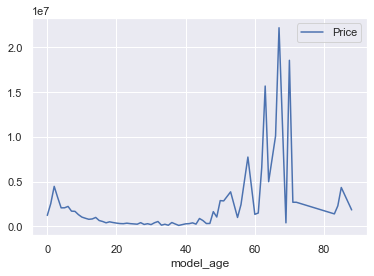

In [200]:
price_by('model_age')

Если посмотреть на период от 0 до 20 лет, то заметно справедливое падение цены с ростом возраста автомобиля. Дальше виден скачок цен авто возрастом от 50 до 70 лет. Возможно, это уже поле редких, раритетных автомобилей, которое формирует выбросы.

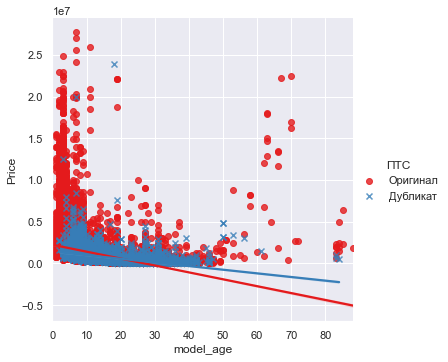

In [201]:
price_plot('model_age')

Старый признак нам больше не нужен.

In [202]:
cols_to_drop_train.append('modelDate')
cols_to_drop_test.append('modelDate')


In [203]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68894 entries, 0 to 68894
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             68894 non-null  object 
 1   brand                68894 non-null  object 
 2   model_name           68894 non-null  object 
 3   color                68894 non-null  object 
 4   fuelType             68894 non-null  object 
 5   modelDate            68894 non-null  float64
 6   name                 68894 non-null  object 
 7   numberOfDoors        68894 non-null  int64  
 8   productionDate       68894 non-null  int64  
 9   vehicleTransmission  68894 non-null  object 
 10  engineDisplacement   68894 non-null  object 
 11  enginePower          68894 non-null  float64
 12  description          66679 non-null  object 
 13  mileage              68894 non-null  int64  
 14  vendor               68894 non-null  object 
 15  Комплектация         68894 non-null 

In [204]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## productionDate

In [205]:
train['vehicle_age'] = 2021 - train['productionDate']

<AxesSubplot:xlabel='vehicle_age'>

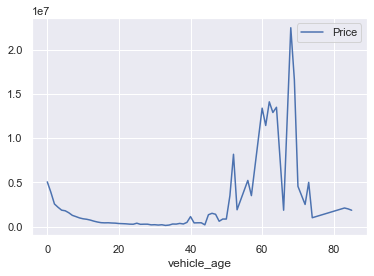

In [206]:
price_by('vehicle_age')

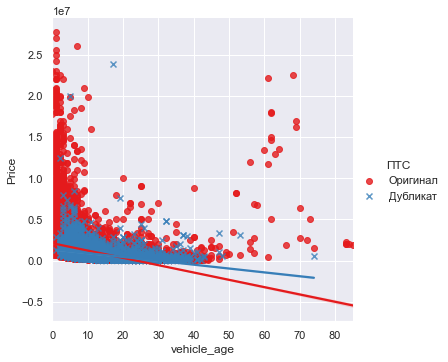

In [207]:
price_plot('vehicle_age')

In [208]:
cols_to_drop_test.append('productionDate')
cols_to_drop_train.append('productionDate')



In [209]:
test['vehicle_age'] = 2021 - test['productionDate']


## Количественные признаки

## engineDisplacement - объём двигателя автомобиля


In [210]:
train['engineDisplacement'].value_counts()

1.6         13933
2.0          9649
1.4          5230
1.8          4006
2.4          2644
            ...  
733i            1
214d            1
335d            1
35is            1
Stingray        1
Name: engineDisplacement, Length: 430, dtype: int64

In [211]:
train['engineDisplacement1'] = train['engineDisplacement'].str.findall(r'\d\.\d').str[0]
train['engineDisplacement1'] = train['engineDisplacement1'].astype('str')

In [212]:
#Заполним в Train engineDisplacement
train['engineDisplacement'] = train['engineDisplacement1']
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: '2.0' if x == 'nan' else x)
train['engineDisplacement'] = train['engineDisplacement'].astype('float32')

In [213]:
train.engineDisplacement.value_counts(dropna=False)

2.0    27151
1.6    14068
1.4     5268
1.8     4067
2.4     3064
       ...  
7.4        2
5.4        2
8.1        1
3.9        1
0.6        1
Name: engineDisplacement, Length: 56, dtype: int64

In [214]:
cols_to_drop_train.append('engineDisplacement1')

In [215]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x[:3])
test.engineDisplacement.value_counts()

2.0    7391
1.6    4973
3.0    3915
1.8    3349
2.5    2477
       ... 
6.6       6
1.1       4
4.9       4
3.9       1
5.3       1
Name: engineDisplacement, Length: 55, dtype: int64

In [216]:
# Есть LT. заменим LT на наиболее частое 2.0 и приведем к типу float
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: 2.0 if x == ' LT' else x)
test['engineDisplacement'] = test['engineDisplacement'].astype('float64')


In [217]:
test['engineDisplacement'].value_counts()

2.0    7446
1.6    4973
3.0    3915
1.8    3349
2.5    2477
       ... 
6.6       6
1.1       4
4.9       4
3.9       1
5.3       1
Name: engineDisplacement, Length: 54, dtype: int64

In [218]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   car_url               34686 non-null  object 
 3   color                 34686 non-null  object 
 4   complectation_dict    6418 non-null   object 
 5   description           34686 non-null  object 
 6   engineDisplacement    34686 non-null  float64
 7   enginePower           34686 non-null  object 
 8   equipment_dict        24690 non-null  object 
 9   fuelType              34686 non-null  object 
 10  image                 34686 non-null  object 
 11  mileage               34686 non-null  int64  
 12  modelDate             34686 non-null  int64  
 13  model_info            34686 non-null  object 
 14  model_name            34686 non-null  object 
 15  name               

## enginePower


In [219]:
train['enginePower'].value_counts()

150.0    5247
123.0    2724
249.0    2396
102.0    1742
105.0    1632
         ... 
321.0       1
40.0        1
41.0        1
477.0       1
134.0       1
Name: enginePower, Length: 338, dtype: int64

In [220]:
train['enginePower'] = train['enginePower'].fillna(train['enginePower'].mode()[0])

In [221]:
test['enginePower'].value_counts()

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
431 N12       1
38 N12        1
61 N12        1
32 N12        1
254 N12       1
Name: enginePower, Length: 315, dtype: int64

In [222]:
test['enginePower'] = test['enginePower'].apply(lambda x: x.split(' ')[0]).astype('int64')


In [223]:
test['enginePower'].value_counts()

249    1708
150    1699
110    1039
170     977
105     955
       ... 
338       1
402       1
626       1
630       1
639       1
Name: enginePower, Length: 315, dtype: int64

<AxesSubplot:xlabel='enginePower'>

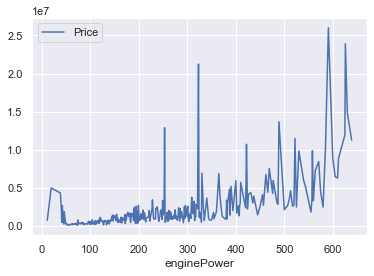

In [224]:
price_by('enginePower')

## mileage

In [225]:
test['mileage'].value_counts()

200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
152129      1
4681        1
461386      1
121424      1
69630       1
Name: mileage, Length: 11268, dtype: int64

In [226]:
train['mileage'].value_counts()

200000    855
250000    764
300000    727
150000    714
180000    614
         ... 
144081      1
277200      1
51918       1
168645      1
135166      1
Name: mileage, Length: 20616, dtype: int64

<AxesSubplot:xlabel='mileage'>

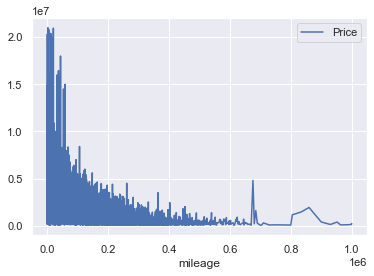

In [227]:
price_by('mileage')

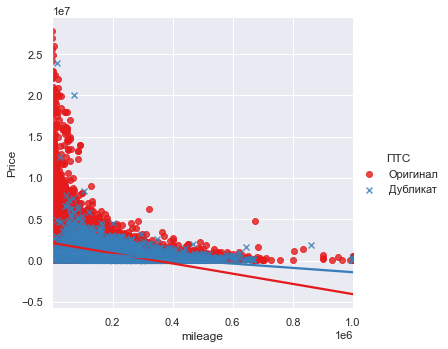

In [228]:
price_plot('mileage')


Создадим список количественных переменных.

In [229]:
num_cols = ['engineDisplacement', 'enginePower','mileage', 'model_age', 'vehicle_age', 'Price']

Посмотрим распределение данных

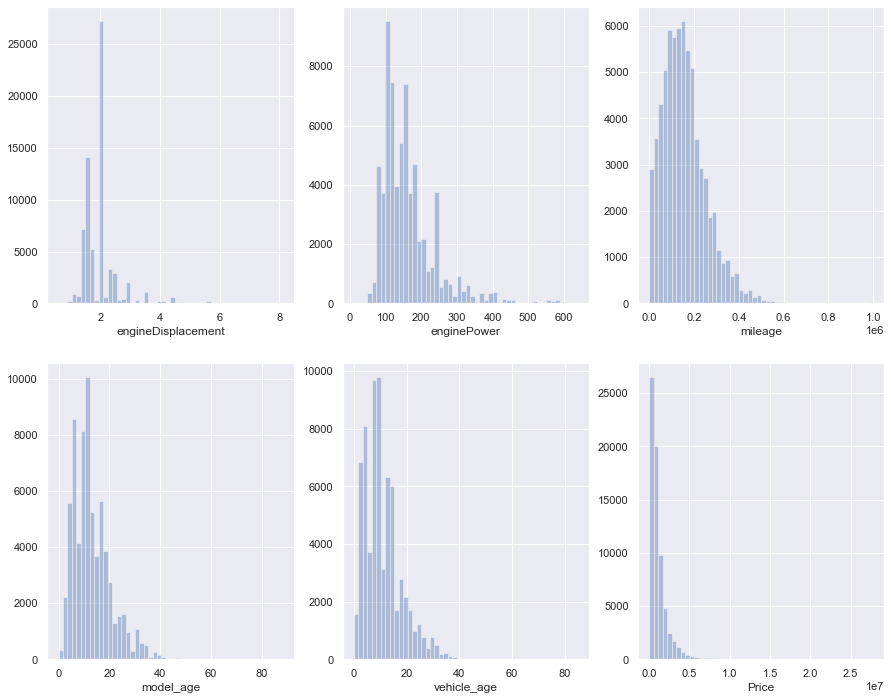

In [230]:
fig, axes = plt.subplots(2,3, figsize=(15, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [231]:
for col in ['engineDisplacement', 'enginePower', 'mileage', 'model_age', 'vehicle_age']:
    d = outliers_iqr(train[col])
    train = train.loc[train[col].between(d[0], d[1])]

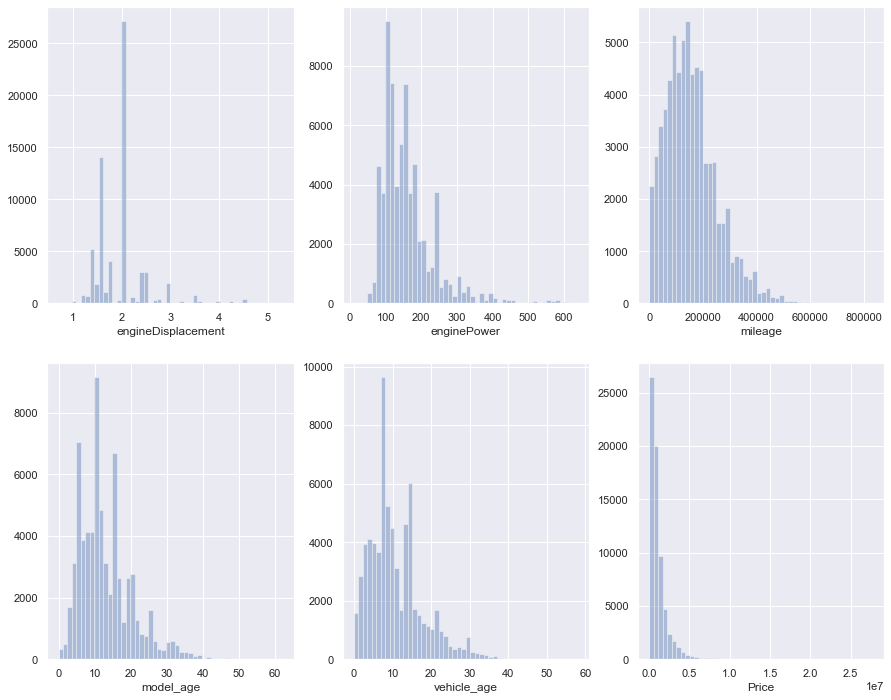

In [232]:
#Посмотрим распределение данных
fig, axes = plt.subplots(2,3, figsize=(15, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])
    
#Прологарифмируем целевую переменную
#train['Price'] = np.log(train['Price'] + 1)

<AxesSubplot:xlabel='vehicle_age'>

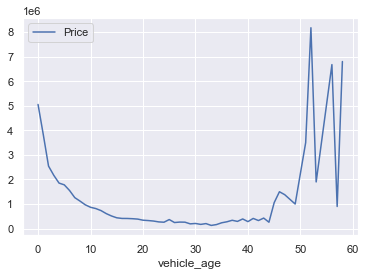

In [233]:
price_by('vehicle_age')


<AxesSubplot:xlabel='enginePower'>

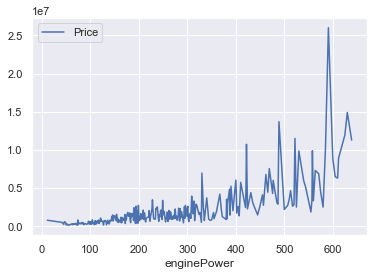

In [234]:
price_by('enginePower')

## Удаляем лишние столбцы

In [235]:
cols_to_drop_test.append('Состояние') # одна категория
cols_to_drop_test.append('priceCurrency') # одна категория
cols_to_drop_test.append('Таможня') # одна категория
cols_to_drop_test.append('model_info') # ячейки не содержат ничего кроме названия модели

cols_to_drop_test.append('super_gen') 
cols_to_drop_test.append('vehicleConfiguration') #тип кузова есть в bodyType, инф. о коробке передач в Transsmition, объем двигателя есть в engineDisplacemen. Можно убрать.
cols_to_drop_test.append('name') #Признак дублирует значения engineDisplacement и enginePower, удаляем его
cols_to_drop_test.append('equipment_dict')
cols_to_drop_test.append('car_url')
cols_to_drop_test.append('image')
cols_to_drop_test.append('complectation_dict')
cols_to_drop_test.append('sell_id')
cols_to_drop_test.append('parsing_unixtime')
cols_to_drop_test.append('description')




cols_to_drop_train.append('Таможня')
cols_to_drop_train.append('name') 
cols_to_drop_train.append('Комплектация') 
cols_to_drop_train.append('description')





In [236]:
test = test.drop(cols_to_drop_test, axis=1)
train = train.drop(cols_to_drop_train, axis=1)


## Посмотрим на значимость переменных

<AxesSubplot:>

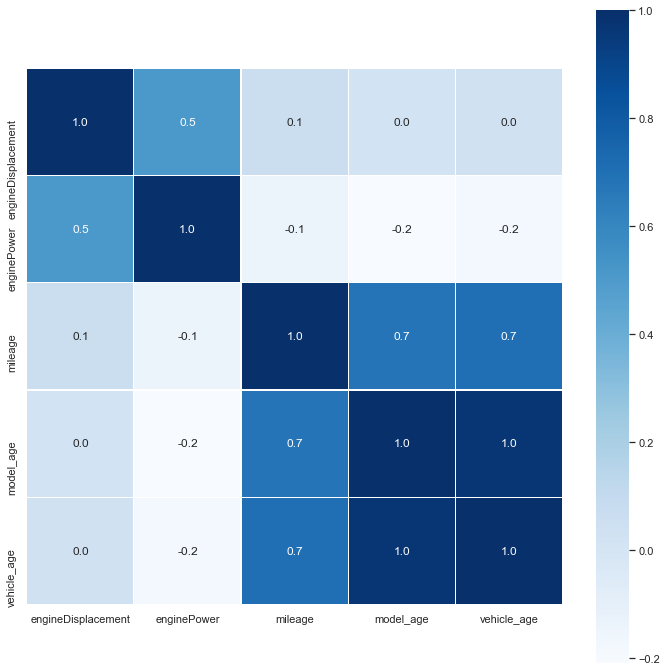

In [237]:
num_cols = [
    'engineDisplacement', 'enginePower', 'mileage', 'model_age', 'vehicle_age']

sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(train[num_cols].corr(),
            square=True,
            annot=True,
            fmt=".1f",
            linewidths=0.1,
            cmap="Blues")

Несмотря на то, что наблюдается очень высокая корреляция между 'model_age' и 'vehicle_age', удаления одного из признаков негативно влияет на показние метрики.

In [238]:
num_cols = [
    'engineDisplacement', 'enginePower', 'mileage', 'model_age', 'vehicle_age']

Text(0.5, 0, 'F-value')

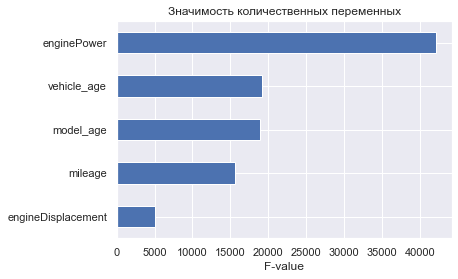

In [239]:
# для оценки непрерывных значений будем использовать функцию f_regression

imp_num = Series(f_regression(train[num_cols], train['Price'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость количественных переменных')
plt.xlabel('F-value')

## Подготовка к обучению

In [240]:
cat_cols = [
    'bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors',
    'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'Привод'
]


bin_cols = [
    'ПТС', 'Руль'
]    


num_cols = [
     'engineDisplacement', 'enginePower', 'mileage',  'model_age', 'vehicle_age'
]


In [241]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
df = train.append(test, ignore_index=True)

In [242]:
df.sample(6)

,bodyType,brand,model_name,color,fuelType,numberOfDoors,vehicleTransmission,engineDisplacement,enginePower,mileage,vendor,Привод,Руль,Владельцы,ПТС,Владение,Price,model_age,vehicle_age,sample
88776,седан,TOYOTA,COROLLA,чёрный,бензин,4,автоматическая,1.6,124.0,73144,JAPANESE,передний,Левый,2,Оригинал,Не указано,NaN,15.0,11,0
70905,седан,AUDI,A4,белый,бензин,4,автоматическая,2.0,211.0,94926,EUROPEAN,полный,Левый,3,Оригинал,Не указано,NaN,14.0,10,0
853,Купе,BMW,4,чёрный,бензин,2,автоматическая,2.0,306.0,107000,EUROPEAN,полный,Левый,2,Оригинал,"{'year': 2016, 'month': 2}",1850000.0,8.0,8,1
49341,Седан,NISSAN,TEANA,чёрный,бензин,4,вариатор,2.5,173.0,150000,JAPANESE,передний,Левый,2,Оригинал,Не указано,1200000.0,7.0,7,1
71778,купе,AUDI,TT,золотистый,бензин,2,роботизированная,2.0,211.0,90000,EUROPEAN,полный,Левый,1,Оригинал,Не указано,NaN,11.0,10,0
17194,Внедорожник 5 дв.,BMW,X1,чёрный,дизель,5,автоматическая,2.0,184.0,149850,EUROPEAN,полный,Левый,2,Оригинал,"{'year': 2016, 'month': 4}",1280000.0,9.0,8,1


In [243]:
df[cat_cols]

,bodyType,brand,color,fuelType,model_name,numberOfDoors,vehicleTransmission,vendor,Владельцы,Владение,Привод
0,Универсал 5 дв.,AUDI,синий,бензин,RS4,5,роботизированная,EUROPEAN,3,"{'year': 2021, 'month': 3}",полный
1,Универсал 5 дв.,AUDI,фиолетовый,бензин,RS4,5,автоматическая,EUROPEAN,1,"{'year': 2019, 'month': 3}",полный
2,Универсал 5 дв.,AUDI,синий,бензин,RS4,5,автоматическая,EUROPEAN,1,Не указано,полный
3,Универсал 5 дв.,AUDI,серый,бензин,RS4,5,автоматическая,EUROPEAN,2,"{'year': 2020, 'month': 3}",полный
4,Компактвэн,HONDA,белый,бензин,MOBILIO,5,вариатор,JAPANESE,2,"{'year': 2012, 'month': 4}",полный
...,...,...,...,...,...,...,...,...,...,...,...
103202,седан,BMW,коричневый,бензин,3ER,4,автоматическая,EUROPEAN,3,2 года и 1 месяц,задний
103203,седан,BMW,чёрный,дизель,5ER,4,автоматическая,EUROPEAN,1,Не указано,полный
103204,седан,BMW,серый,бензин,5ER,4,автоматическая,EUROPEAN,3,Не указано,задний
103205,внедорожник 5 дв.,BMW,коричневый,дизель,X1,5,автоматическая,EUROPEAN,2,Не указано,полный


## Label Encoding

In [244]:
label_cat_cols = [
    'bodyType', 'brand', 'color', 'fuelType', 'model_name',
    'vehicleTransmission', 'vendor', 'Владение', 'Привод'
]

In [245]:
encoder = LabelEncoder()


In [246]:
for column in label_cat_cols:
    encoder.fit(df[column])
    df[column] = encoder.transform(df[column])

In [247]:
df[cat_cols]

,bodyType,brand,color,fuelType,model_name,numberOfDoors,vehicleTransmission,vendor,Владельцы,Владение,Привод
0,89,0,13,0,549,5,3,1,3,559,2
1,89,0,14,0,549,5,0,1,1,538,2
2,89,0,13,0,549,5,0,1,1,562,2
3,89,0,12,0,549,5,0,1,2,550,2
4,16,3,1,0,420,5,1,2,2,455,2
...,...,...,...,...,...,...,...,...,...,...,...
103202,139,1,6,0,28,4,0,1,3,132,0
103203,139,1,15,3,33,4,0,1,1,562,2
103204,139,1,12,0,33,4,0,1,3,562,0
103205,125,1,6,3,740,5,0,1,2,562,2


Перекодируем бинарные признаки


In [248]:
lbl_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = lbl_encoder.fit_transform(df[column])

Проверим значимость бинарных и категориальных признаков

<AxesSubplot:>

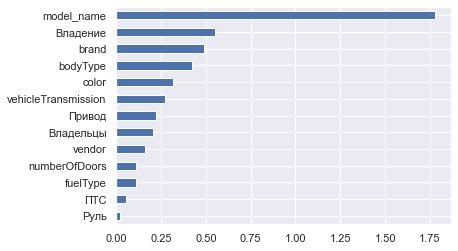

In [249]:
imp_cat = Series(mutual_info_classif(df[df['sample'] == 1][bin_cols + cat_cols], df[df['sample'] == 1]['Price'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [250]:
df.head()

,bodyType,brand,model_name,color,fuelType,numberOfDoors,vehicleTransmission,engineDisplacement,enginePower,mileage,vendor,Привод,Руль,Владельцы,ПТС,Владение,Price,model_age,vehicle_age,sample
0,89,0,549,13,0,5,3,4.2,450.0,122000,1,2,0,3,2,559,2100000.0,9.0,8,1
1,89,0,549,14,0,5,0,2.9,450.0,23650,1,2,0,1,2,538,6650000.0,4.0,3,1
2,89,0,549,13,0,5,0,2.9,450.0,7878,1,2,0,1,2,562,7900000.0,4.0,2,1
3,89,0,549,12,0,5,0,2.9,450.0,42000,1,2,0,2,2,550,6190000.0,4.0,4,1
4,16,3,420,1,0,5,1,1.5,90.0,350000,2,2,1,2,2,455,355000.0,17.0,14,1


In [251]:
# разделяем наш объединенный ранее датасет на первоначальные части - train_df и test_df

train_dfm = df[df['sample'] == 1].drop(['sample'], axis=1)
test_dfm = df[df['sample'] == 0].drop(['sample'], axis=1)

In [252]:

X = train_dfm.drop(['Price'], axis=1).values
y = train_dfm['Price'].values

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Обучение

## 1. Линейна регрессия

In [254]:
# Обучаем классификатор
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print(f"Test MAPE: {mape(y_test, y_pred)*100:0.3f}%")

Test MAPE: 83.789%


## 2. Random Forest


In [255]:
# Параметры леса по умолчанию 
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

Test MAPE: 13.754 %


Попробуем подобрать значения для некоторых параметров с помощью RandomizedSearchCV

In [256]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=1200, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [257]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, scoring="neg_mean_absolute_error", param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
best_parameters = rf_random.best_params_
print(f'Лучшие значения параметров:')
for param_name in sorted(best_parameters.keys()):
    print('  %s = %r,' % (param_name, best_parameters[param_name]))

In [1316]:
# Построим RandomForest на лучших параметрах
bestparams_rf = RandomForestRegressor(random_state=RANDOM_SEED,
                                      max_depth=None,
                                      max_features='auto',
                                      min_samples_leaf=1,
                                      min_samples_split=2,
                                      n_estimators=500)
bestparams_rf.fit(X_train, y_train)
y_pred = bestparams_rf.predict(X_test)

print(f"Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

Test MAPE: 14.056 %


## 3. Bagging


In [1317]:
# Точность одного дерева
tree = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(f"Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

Test MAPE: 18.568 %


In [1318]:
# Обернем деревья в BaggingRegressor
tree = DecisionTreeRegressor(max_features=int(
    X_train.shape[1]/3), max_depth=77, random_state=RANDOM_SEED)
bagging_trees = BaggingRegressor(tree, random_state=RANDOM_SEED)
bagging_trees.fit(X_train, y_train)
y_pred = bagging_trees.predict(X_test)
print(
    f"BaggingRegressor(DecisionTrees) Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")


BaggingRegressor(DecisionTrees) Test MAPE: 15.679 %


## 4. GradientBoosting Regressor


In [1319]:
# Запустим с параметрами по умолчанию.
gb = GradientBoostingRegressor(random_state=RANDOM_SEED)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(
    f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

GradientBoostingRegressor Test MAPE: 24.588 %


Попробуем провести поиск наилучших параметров
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=800, num=8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

gbr = GradientBoostingRegressor()
gbr_r = RandomizedSearchCV(estimator=gbr, scoring="neg_mean_absolute_error", param_distributions=random_grid,
                           n_iter=100, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
gbr_r.fit(X_train, y_train)
gbr_r.best_params_

best_parameters = gbr_r.best_params_
print(f'Лучшие значения параметров:')
for param_name in sorted(best_parameters.keys()):
    print('  %s = %r,' % (param_name, best_parameters[param_name]))

In [1320]:
# Запустим с найденными лучшими параметрами.
gb_bestpar = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                       max_depth=7,
                                       max_features='auto',
                                       min_samples_leaf=2,
                                       min_samples_split=2,
                                       n_estimators=500)
gb_bestpar.fit(X_train, y_train)
y_pred = gb_bestpar.predict(X_test)
print(
    f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

GradientBoostingRegressor Test MAPE: 14.271 %


Результаты улучшились в сравнении с полученными с параметрами по умолчанию.


## 5. Bagging + GradientBoosting Regressor


In [1321]:
# Запустим с GradientBoosting Regressor c найденными ранее оптимальными параметрами.
gb_bb = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                  max_depth=7,
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  n_estimators=500,
                                  max_features=int(X_train.shape[1]/3))
gb_bb.fit(X_train, y_train)
y_pred = gb_bb.predict(X_test)
print(
    f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

GradientBoostingRegressor Test MAPE: 14.446 %


In [1322]:
# Обернем GradientBoosting Regressor в BaggingRegressor
bagging_gb = BaggingRegressor(gb_bb, random_state=RANDOM_SEED)
bagging_gb.fit(X_train, y_train)
y_pred = bagging_gb.predict(X_test)
print(
    f"Bagging+GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

Bagging+GradientBoostingRegressor Test MAPE: 13.963 %


In [1323]:
## 6. Stacking

In [1324]:
X_pred = test_dfm.drop(['Price'], axis=1).values


In [1325]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


def compute_metric(regressor, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    regressor.fit(X_train, y_train)
    y_test_pred = regressor.predict(X_test)
    return np.round(mape(y_test, y_test_pred)*100, 4)


In [1326]:
def compute_meta_feature(regressor, X_train, X_test, y_train, cv, X_pred):

    X_meta_train = np.zeros_like(y_train, dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regressor)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regressor)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)
    X_meta_pred = meta_regr.predict(X_pred)

    return X_meta_train, X_meta_test, X_meta_pred

In [1327]:
def generate_meta_features(regressors, X_train, X_test, y_train, cv, X_pred):

    features = [
        compute_meta_feature(regr, X_train, X_test, y_train, cv, X_pred) for regr in tqdm(regressors)
    ]
    stacked_features_train = np.vstack([
        features_train for features_train, features_test, features_pred in features
    ]).T
    stacked_features_test = np.vstack([
        features_test for features_train, features_test, features_pred in features
    ]).T
    stacked_features_pred = np.vstack([
        features_pred for features_train, features_test, features_pred in features
    ]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred

In [1328]:
# получаем метапризнаки:
stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features([
    RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,
                          max_features=7, max_depth=77, bootstrap=True, random_state=RANDOM_SEED),
    AdaBoostRegressor(random_state=RANDOM_SEED),
    ExtraTreesRegressor(random_state=RANDOM_SEED),
    RandomForestRegressor(random_state=RANDOM_SEED)], X_train, X_test, y_train, cv, X_pred)

# инициализируем метаалгоритм
stacked_regr1 = RandomForestRegressor(random_state=RANDOM_SEED,
                                      max_depth=None,
                                      max_features='auto',
                                      min_samples_leaf=1,
                                      min_samples_split=2,
                                      n_estimators=500)
metric = compute_metric(stacked_regr1, X_train=stacked_features_train,
                        y_train=y_train, X_test=stacked_features_test, y_test=y_test)

# измеряем качество алгоритма на метапризнаках:
print(f'Stacking MAPE = {metric} %')

  0%|          | 0/4 [00:00<?, ?it/s]

Stacking MAPE = 14.4198 %


## Лучший результат мы получили на модели:
5. Bagging + GradientBoosting Regressor. Повторим ее результаты и будем готовить Submission

In [1332]:
# Запустим с GradientBoosting Regressor c найденными ранее оптимальными параметрами.
gb_bb = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                  max_depth=7,
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  n_estimators=500,
                                  max_features=int(X_train.shape[1]/3))
gb_bb.fit(X_train, y_train)
y_pred = gb_bb.predict(X_test)
print(
    f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

# Обернем GradientBoosting Regressor в BaggingRegressor
bagging_gb = BaggingRegressor(gb_bb, random_state=RANDOM_SEED)
bagging_gb.fit(X_train, y_train)
y_pred = bagging_gb.predict(X_test)
print(
    
    f"Bagging+GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")


GradientBoostingRegressor Test MAPE: 14.446 %
Bagging+GradientBoostingRegressor Test MAPE: 13.963 %


## Submission

In [1333]:
X_subm = test_dfm.drop(['Price'], axis=1).values
y_subm = bagging_gb.predict(X_subm)





In [1334]:
sample_submission['price'] = np.round(y_subm, 0)
sample_submission.to_csv('submission_5.csv', index=False)
sample_submission.head(10)


,sell_id,price
0,1100575026,648744.0
1,1100549428,884010.0
2,1100658222,1010604.0
3,1100937408,728546.0
4,1101037972,848601.0
5,1100912634,803059.0
6,1101228730,772734.0
7,1100165896,389183.0
8,1100768262,1992634.0
9,1101218501,1040550.0


## ИТОГИ

Что получилось:
    
    Были спарсены данные почти 69000 авто. Данные вполне пригодны для обучения.
    Мы очистили данные, поработали с выбросами.
    Добавили пару новых признаков.
    Обучили модели, опробовали несколько алгоритмов.
    Поэкспериментировали с настройками моделей.
    

Результат на Kaggle - 19.65685.


Что хотелось бы сделать еще при наличии доп. времени:
    Сгенерировать новые признаки. Например, извлечь ключевые слова из 'description'.
    Поэкспериментировать с другими алгоритмами.